In [7]:
import matplotlib.pyplot as plt
import optuna
import numpy as np
from optuna.samplers import TPESampler

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp, lf_lp_options

In [8]:

def oversample(signal, num_samples):
    original_length = signal.shape[0]
    indices = np.linspace(0, original_length - 1, num_samples)
    interpolated_signal = np.interp(indices, np.arange(original_length), signal)
    return interpolated_signal

def neuron_output(neuron, rolling_window, duration, signal_freq, shift_degrees=0):
    y_events = neuron.out_spikes()
    cycles = 5
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > (duration - ((5+cycles)/signal_freq)) * clk_freq + shift_samples) &
        (y_events < (duration - (5/signal_freq)) * clk_freq + shift_samples)
    ]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    return y_spikes_rollsum

def generate_and_input_signal(resonator, duration, f):
    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * f
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

def resonator_from_optuna(freq0, lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain=1, clk_freq=1_536_000):
    LF, LP, f_resonator = lf_lp_options(freq0, clk_freq)[lf_lp_option]
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000 * amplitude_gain)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weight_input, -weight_feedback], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_input
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def shift(signal, shift_by, waves):
    delta = np.zeros(len(signal))
    wave_length = len(signal)/waves
    shift_by *= wave_length/(2*np.pi)
    delta[int(shift_by)] = 1.0
    fft_delta = np.fft.fft(delta)
    fft_signal = np.fft.fft(signal)*fft_delta
    shifted_signal = np.fft.ifft(fft_signal)
    return shifted_signal.real

def objective(trial):
    gain = max(1, freq0 / 104)
    theta_input=trial.suggest_int('theta_input', -int(gain*15), int(gain*1))
    theta=trial.suggest_int('theta', -int(gain*15), -int(gain*1))
    weight_input=trial.suggest_int('weight_input', int(gain*5), int(gain*15))
    weight_feedback=trial.suggest_int('weight_feedback', int(gain*5), int(gain*15))
    weight=trial.suggest_int('weight', int(gain*5), int(gain*15))
    amplitude_gain=1

    resonator = resonator_from_optuna(freq0, lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain, clk_freq)
    return  score_resonator(resonator, duration=.3, freq0=freq0)

def score_resonator(resonator, duration, freq0, plot=False):
    for i in range(0, 5):
        resonator.log_out_spikes(i)

    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * freq0
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

    try:
        spikes_roll = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
                                for i in range(0, 5)])
    except ValueError:
        return np.inf

    if plot:
        for i in range(5):
            plt.plot(spikes_roll[i], label=f'output of {i}')
        plt.legend()
    mse = 0
    for i in range(0, 4):
        mse += ((ground_truth[i] - spikes_roll[i+1]) ** 2).mean()
    return mse

In [9]:
freq0 = 104
freq_gt = 30
clk_freq = 1536000
duration = 1.2
spikes_window_size = 500
lf_lp_option = 4

base_params = {
    'theta_input': -1,
    'theta': -5,
    'weight_input': 11,
    'weight_feedback': 9,
    'weight': 10,
}
resonator = resonator_from_optuna(freq_gt, **base_params, lf_lp_option=5, clk_freq=clk_freq)
desired_resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
desired_resonator.log_out_spikes(0)
for i in range(0, 5):
    resonator.log_out_spikes(i)
generate_and_input_signal(resonator, duration, freq_gt)
generate_and_input_signal(desired_resonator, duration, freq0)
ground_truth_104 = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, freq_gt) for i in range(0, 5)])

phase_shift = 0
ground_truth = []
for i in range(1, 5):
    j = i - 1
    norm_x0 = (ground_truth_104[j] - np.min(ground_truth_104[j])) / (np.max(ground_truth_104[j]) - np.min(ground_truth_104[j])) * 2 - 1
    max_xi = ground_truth_104[i].max()
    min_xi = ground_truth_104[i].min()
    norm_x1 = (ground_truth_104[i] - min_xi) / (max_xi - min_xi) * 2 - 1
    phase_shift -= np.mean(np.abs((np.arcsin(norm_x0) - np.arcsin(norm_x1)))*180/np.pi)
    gt_i = neuron_output(desired_resonator.neurons[0], spikes_window_size, duration, freq0, phase_shift)
    gt_i = (gt_i - gt_i.min())/(gt_i.max() - gt_i.min())
    gt_i = gt_i * (max_xi - min_xi) + min_xi
    ground_truth.append(gt_i)
    # plt.plot(gt_i, label=f'gt {i}')

ground_truth = np.array(ground_truth)
if freq0 == freq_gt:
    # for testing the mse of the ground truth vs what we are searching
    mse = score_resonator(resonator, duration=.3, freq0=freq0, plot=True)
    print(f'mse {mse}')

In [47]:
import time

study_name = f'Study{clk_freq}-{freq0}'
study = optuna.create_study(study_name=study_name,
                            pruner=optuna.pruners.HyperbandPruner(),
                            sampler=TPESampler(seed=43),
                            direction='minimize',
                            load_if_exists=True)

[I 2023-06-15 16:36:28,652] A new study created in memory with name: Study1536000-47


In [53]:
ts = time.time()
study.optimize(objective, n_trials=100)
print(f'{time.time() - ts} seconds.')

[I 2023-06-15 16:38:28,660] Trial 100 finished with value: 100387.05876327836 and parameters: {'theta_input': -2, 'theta': -1, 'weight_input': 12, 'weight_feedback': 8, 'weight': 5}. Best is trial 98 with value: 24888.993145682936.
[I 2023-06-15 16:38:29,378] Trial 101 finished with value: 25594.15567499432 and parameters: {'theta_input': -2, 'theta': -2, 'weight_input': 13, 'weight_feedback': 9, 'weight': 5}. Best is trial 98 with value: 24888.993145682936.
[I 2023-06-15 16:38:30,082] Trial 102 finished with value: 25288.638850874893 and parameters: {'theta_input': -1, 'theta': -2, 'weight_input': 13, 'weight_feedback': 9, 'weight': 5}. Best is trial 98 with value: 24888.993145682936.
[I 2023-06-15 16:38:30,788] Trial 103 finished with value: 142641.09593195232 and parameters: {'theta_input': -1, 'theta': -1, 'weight_input': 13, 'weight_feedback': 9, 'weight': 6}. Best is trial 98 with value: 24888.993145682936.
[I 2023-06-15 16:38:31,494] Trial 104 finished with value: 25288.63885087

72.57861757278442 seconds.


mse 14985.01147680641


{'theta_input': -1,
 'theta': -3,
 'weight_input': 7,
 'weight_feedback': 5,
 'weight': 6}

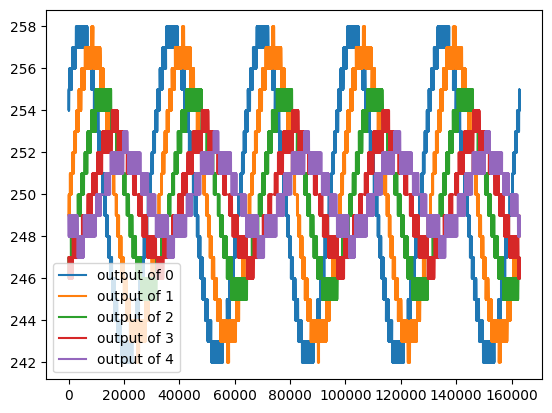

In [54]:
# 118 {'theta_input': -1.161, 'theta': -4.943, 'weight_input': 8.512, 'weight_feedback': 8.867, 'weight': 10.342}
best_params = study.best_params.copy()

resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
# resonator = resonator_from_optuna(freq0, **base_params, clk_freq=clk_freq)
mse = score_resonator(resonator, duration=.3, freq0=freq0, plot=True)
print(f'mse {mse}')
best_params

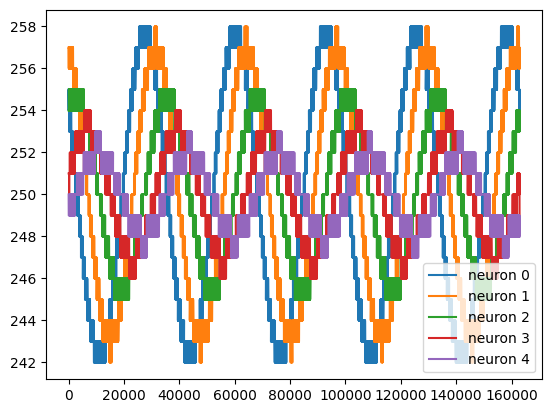

In [55]:
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

generate_and_input_signal(resonator, duration, freq0)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


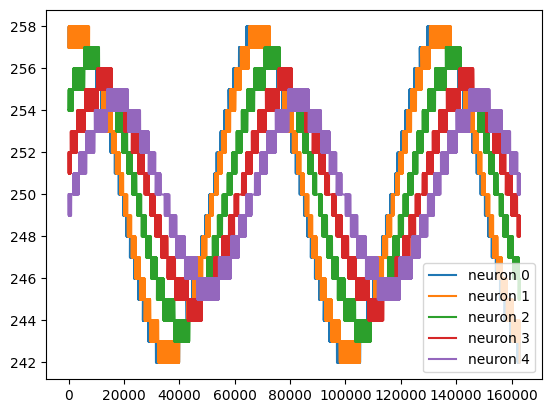

In [56]:
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)


generate_and_input_signal(resonator, duration, freq0 / 2)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


In [6]:
from snn.resonator import lp_by_lf, freq_of_resonator

start_freq = 0
spectrum = 2 * freq0
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
# resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
resonator.log_out_spikes(-1)

step = 1 / 40000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
spikes_window_size = 500
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

best_lp = lp_by_lf(lf_lp_option, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf_lp_option, best_lp)
plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} LF: {lf_lp_option}')
plt.plot(x, y_spikes)
plt.show()

NameError: name 'best_params' is not defined

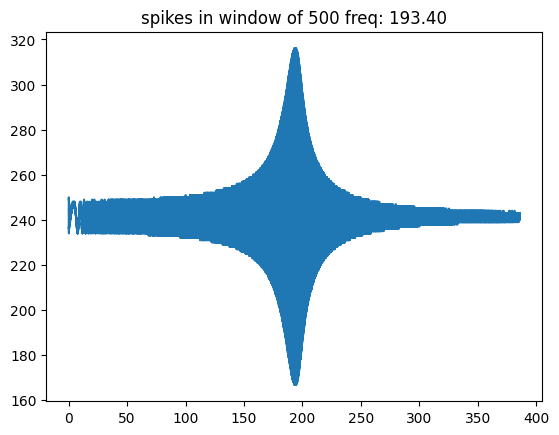

In [16]:
from snn.resonator import lp_by_lf, freq_of_resonator

start_freq = 0

params = {
    "theta_input": -3,
    "theta": -17,
    "weight_input": 49,
    "weight_feedback": 45,
    "weight": 34,
}
freq0 = 193
lf_lp_option = 4

spectrum = 2 * freq0
resonator = resonator_from_optuna(freq0, **params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
resonator.log_out_spikes(-1)

step = 1 / 40000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
spikes_window_size = 500
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

best_lp = lp_by_lf(lf_lp_option, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf_lp_option, best_lp)
plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f}')
plt.plot(x, y_spikes)
plt.show()